In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
# Causality param
eps = 5

device = torch.device('cpu')

# Define the exact solution
def exact_solution(x, t):
    return torch.sin(x)*torch.exp(t)

def initial_condition(x):
    return torch.sin(x)

def initial_condition_t(x):
    return torch.sin(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = 8*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init = torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition(init[:,0]).reshape(-1, 1).to(device)
u_init_t = initial_condition(init[:,0]).reshape(-1, 1).to(device)

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = 0*torch.sin(tb_left).to(device)

xb_right = 8*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = 0*torch.sin(2*pi - tb_right).to(device)

x_int = torch.linspace(0, 8*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero

training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), u_init.to(device), u_init_t.to(device), b_left.to(device),  b_right.to(device), u_b_l.to(device), u_b_r.to(device)), batch_size=500, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [6]:
def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_eb1.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# # after defining my network - also dont forget to comment xavier
# my_network.load_state_dict(model_state_dict)
# my_network = my_network.to(device)
# # after defining my network - also dont forget to comment xavier
# my_network.load_state_dict(model_state_dict)

In [7]:

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right, ubl, ubr) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                u_initial_pred_ = model(initial)
                inputs = torch.ones(initial_pts, 1).to(device)
                grad_u_init = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs, create_graph=True)[0]
                u_init_t = grad_u_init[:, 1].reshape(-1, )

                # for left boundary
                bd_left.requires_grad = True
                bd_left_pred_ = model(bd_left)
                inputs = torch.ones(left_boundary_pts, 1).to(device)
                grad_bd_left = torch.autograd.grad(bd_left_pred_, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_left = grad_bd_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_left = torch.autograd.grad(u_bd_x_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_left = grad_u_bd_x_left[:, 0].reshape(-1, )
                #inputs = torch.ones(left_boundary_pts, 1).reshape(-1, )
                #grad_u_bd_xx_left = torch.autograd.grad(u_bd_xx_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                #u_bd_xxx_left = grad_u_bd_xx_left[:, 0].reshape(-1, )

                # for right boundary
                bd_right.requires_grad = True
                bd_right_pred_ = model(bd_right)
                inputs = torch.ones(right_boundary_pts, 1).to(device)
                grad_bd_right = torch.autograd.grad(bd_right_pred_, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_right = grad_bd_right[:, 0].reshape(-1, )
                inputs = torch.ones(right_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_right = torch.autograd.grad(u_bd_x_right, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_right = grad_u_bd_x_right[:, 0].reshape(-1, )

                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xx = grad_u_x[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxx = grad_u_xx[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxxx = grad_u_xxx[:, 0].reshape(-1, )

                u_t = grad_u_hat[:, 1]
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                u_tt = grad_u_t[:, 1].reshape(-1, )

                pde_single_column = (u_tt.reshape(-1, ) + u_xxxx.reshape(-1, ) + \
                                     u_hat.reshape(-1, ) - 3*torch.sin(interior[:,0])*torch.exp(interior[:,1])) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                # Item 1. below

                loss_ic = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )) ** p) + \
                          torch.mean((u_init_t.reshape(-1, ) - u_initial_t.reshape(-1, )) ** p)
                #loss_pde = torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, )) ** p)
                loss_left_b = torch.mean((bd_left_pred_.reshape(-1, )) ** p) + \
                              torch.mean((u_bd_xx_left.reshape(-1, )) ** p)
                loss_right_b = torch.mean((bd_right_pred_.reshape(-1, )) ** p) + \
                               torch.mean((u_bd_xx_right.reshape(-1, )) ** p)

                loss = loss_ic + loss_pde + loss_left_b + loss_right_b

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [8]:
# n_epochs = 10000
# start_time = time.time()
# n_epochs = 1500
# history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
# end_time = time.time()
# total_time = end_time - start_time

# print("Training time: {:.2f} seconds".format(total_time))

# with open('p_ic.pkl', 'wb') as f:
#     pickle.dump(history, f)

# f.close()

# model_state_dict = my_network.state_dict()

# # Save the model state dictionary to a file
# torch.save(model_state_dict, 'p_ic.pth')



In [9]:
# Load the history from the pickle file
with open('p_ic.pkl', 'rb') as f:
    history = pickle.load(f)

# # Load the model architecture
# my_network = your_model_module.YourModelClass()  # Instantiate your model class

# Load the saved model state dictionary
model_state_dict = torch.load('p_ic.pth', map_location=torch.device('cpu'))

# Load the model weights
my_network.load_state_dict(model_state_dict)


<All keys matched successfully>

Relative Error Test:  0.0028635700800805353 %


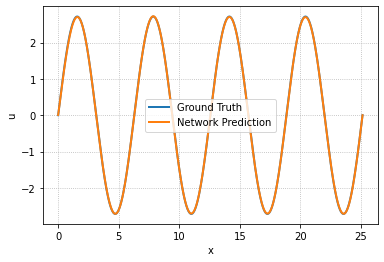

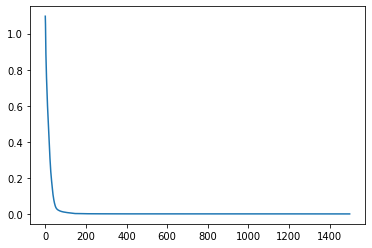

In [10]:
x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.show()

plt.plot(history)
plt.show()



Relative Error Test:  0.0028635700800805353 %


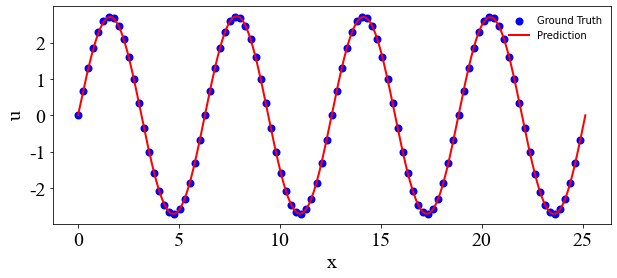

In [34]:


x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

#plt.grid(True, which="both", ls=":")

# Set Times New Roman font for axes labels and ticks

plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False

font_path = 'times-new-roman.ttf'
ticks_font = FontProperties(fname=font_path, size=14)
plt.xlabel("x", fontsize=20, fontproperties=ticks_font)
plt.ylabel("u", fontsize=20, fontproperties=ticks_font)

# Set Times New Roman font for ticks
plt.xticks(fontsize=20, fontproperties=ticks_font)
plt.yticks(fontsize=20, fontproperties=ticks_font)
#plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.scatter(x_test[::100], u_test[::100], label="Ground Truth", color='blue', lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Prediction",color='red', lw=2)
legend_font = FontProperties(family='Times New Roman', style='normal', size=30)

#
plt.legend(loc='upper right', frameon=False)
plt.savefig('diff_ic_dotted.pdf', dpi = 500, bbox_inches = "tight", format='pdf', backend='cairo')
plt.show()

# plt.plot(history)
# plt.show()



In [ ]:
x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")



In [ ]:


# Generate data
x_test = torch.linspace(0, 8 * np.pi, 10000).reshape(-1, 1)
t_test = torch.ones((10000, 1))
test = torch.cat([x_test, t_test], 1)
u_test = exact_solution(x_test, t_test).reshape(-1, 1)

my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1, 1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test) ** 2) / torch.mean(u_test ** 2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

# Create a plot with a white background
plt.figure(figsize=(10, 6), facecolor='white')
plt.grid(True, which="both", ls=":")

# Create the plot for Ground Truth
plt.scatter(x_test[::200], u_test[::200], label="Ground Truth", color='blue', lw=2)

# Create the plot for Network Prediction using dots
plt.plot(x_test, u_test_pred.detach(), 'r', label="Network Prediction")

# Set Times New Roman font for axes labels and ticks
font_path = 'times-new-roman.ttf'
ticks_font = FontProperties(fname=font_path, size=14)
plt.xlabel("x", fontsize=14, fontproperties=ticks_font)
plt.ylabel("u", fontsize=14, fontproperties=ticks_font)

# Set Times New Roman font for ticks
plt.xticks(fontsize=14, fontproperties=ticks_font)
plt.yticks(fontsize=14, fontproperties=ticks_font)

# Labels and legend
plt.legend()

# Show the plot
plt.show()
